In [1]:
!pip install tensorflow==2.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 7.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.

# Import libraries

In [2]:
import os
import sys
import time
import numpy as np
from pathlib import Path
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


# Check TensorFlow version and GPU
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

2025-12-15 15:28:52.589411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765812532.800913      71 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765812532.863789      71 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU available: True


# Load preprocess.py in kaggle notebook

In [3]:
# Use the TRAIN folder for training
data_dir = Path('/kaggle/input/lro-imagery-for-lrocnet-moon-classifier/raw_data/')

In [4]:
sys.path.insert(0, '/kaggle/input/preprocessor2')

In [5]:
#Model using full data set + weighted sampling
from preprocess import load_data, CLASS_NAMES
train_ds, val_ds, test_ds, train_count, val_count, test_count = load_data(data_dir,
                                                                          model_type='vgg16',
                                                                          normalization='model',  
                                                                          batch_size=32,
                                                                          seed=1,
                                                                          train_balanced = False,
                                                                          train_weighted_sampling = False,
                                                                          augment_train = True)

Loading data for vgg16
Normalization: model
Batch size: 32
Training: TensorFlow augmentation ENABLED (rotation, flip, brightness, contrast, zoom)


I0000 00:00:1765812547.691776      71 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765812547.692498      71 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Data loaded:
Training: 3608 images (112 batches)
Validation: 613 images (19 batches)
Test: 779 images (24 batches)


# Create a transfer learning model using VGG16

In [6]:
# 2. Compute class weights -> Original counts: ejecta, oldcrater, none
y_train = [0]*358 + [1]*594 + [2]*2656
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 3.359404096834264, 1: 2.0246913580246915, 2: 0.4528112449799197}


In [7]:
#Create transfer learning model
def load_model():
    model = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(227, 227, 3))
    return model

def set_nontrainable_layers(model):
    model.trainable = False  # Freeze all conv layers initially
    return model

In [8]:
model_vgg16 = load_model()
model_vgg16 = set_nontrainable_layers(model_vgg16)
model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 227, 227, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 227, 227, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 227, 227, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 113, 113, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 113, 113, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
#Build a complete model and add flatten and dense layers
model = models.Sequential([
    model_vgg16,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(CLASS_NAMES), activation="softmax")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [11]:
def fine_tune_model(model, unfreeze_last_n=8, lr=1e-5):
    """
    Unfreeze the last N layers of the backbone and recompile model
    """
    backbone = model.layers[0]
    
    # Unfreeze last N layers
    for layer in backbone.layers[-unfreeze_last_n:]:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [12]:
model = fine_tune_model(model, unfreeze_last_n=8, lr=1e-5)

# Define callback functions

In [13]:
#Early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '/kaggle/working/Transfer_Model_best_classweights.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint]

# Train model

In [14]:
#Train model
start_time = time.time()

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=class_weights,   # Use class weights instead of oversampling
    verbose=1
)

end_time = time.time()
total_time = end_time -start_time

Epoch 1/50


I0000 00:00:1765812554.068945     112 service.cc:148] XLA service 0x7f4208004d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765812554.069844     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765812554.069864     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765812554.805143     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765812571.959743     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.4055 - loss: 2.5033
Epoch 1: val_loss improved from inf to 0.94636, saving model to /kaggle/working/Transfer_Model_best_classweights.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 76s 490ms/step - accuracy: 0.4062 - loss: 2.4953 - val_accuracy: 0.6052 - val_loss: 0.9464
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.5654 - loss: 1.0512
Epoch 2: val_loss improved from 0.94636 to 0.79248, saving model to /kaggle/working/Transfer_Model_best_classweights.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 319ms/step - accuracy: 0.5658 - loss: 1.0500 - val_accuracy: 0.7227 - val_loss: 0.7925
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6242 - loss: 0.9630
Epoch 3: val_loss improved from 0.79248 to 0.77900, saving model to /kaggle/working/Transfer_Model_best_classweights.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 345ms/step - accuracy: 0.6246 - loss: 0.9617 - val_accuracy: 0.7178 - val_loss: 0.7790
Epoch 4/50
113/113 ━━━

In [15]:
total_time

586.2479827404022

# Validation curves

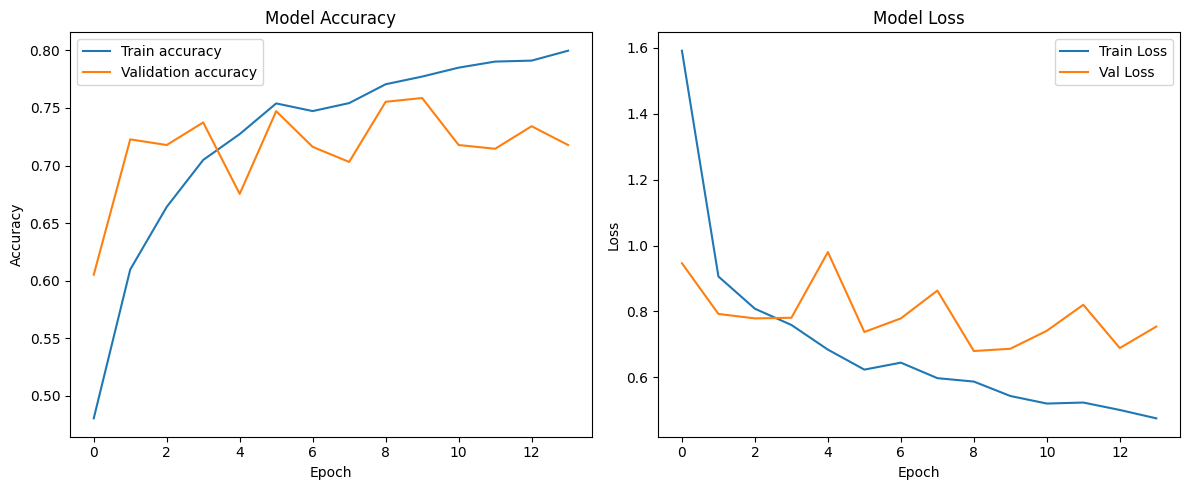

In [16]:
#Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = "Train accuracy")
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion matrix

In [17]:
#Confusion matrix on validation data
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)   #Shape: (batch_size, num_classes)
    preds_labels = np.argmax(preds, axis = 1) #Convert probabilities to class indices

    y_true.extend(labels.numpy())
    y_pred.extend(preds_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


In [18]:
def plot_confusion_matrix(y_true, y_pred, class_names, figsize=(8,6), cmap="YlGnBu"):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Create annotation text: "85%\n(47)"
    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            pct = cm_norm[i, j] * 100
            count = cm[i, j]
            annotations[i, j] = f"{pct:.0f}%\n({count})"

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm_norm, 
        annot=annotations, 
        fmt="", 
        cmap=cmap,
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5,
        linecolor="gray"
    )
    
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.title("Confusion Matrix (Percentages + Counts)", fontsize=14)
    plt.tight_layout()
    plt.show()

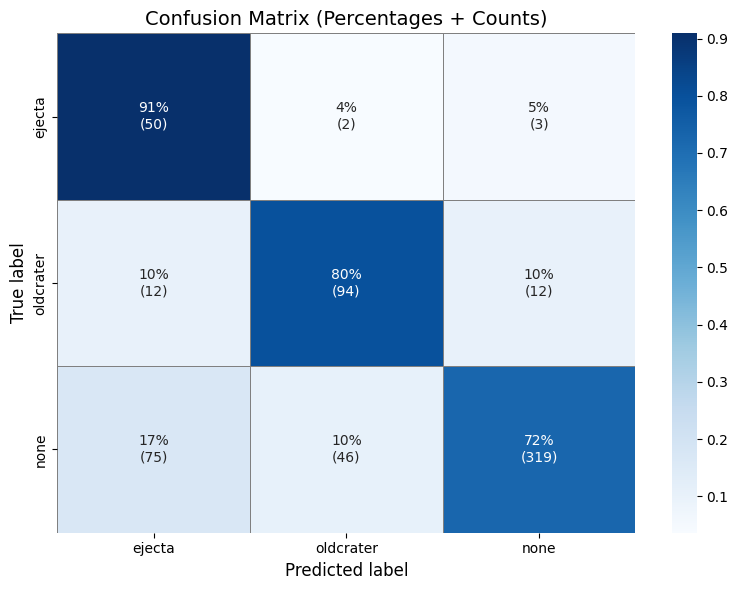

In [19]:
plot_confusion_matrix(y_true, y_pred, CLASS_NAMES, cmap="Blues")

# Classification report

In [20]:
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      ejecta       0.36      0.91      0.52        55
   oldcrater       0.66      0.80      0.72       118
        none       0.96      0.72      0.82       440

    accuracy                           0.76       613
   macro avg       0.66      0.81      0.69       613
weighted avg       0.85      0.76      0.78       613



In [21]:
# 8. Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 522ms/step - accuracy: 0.7953 - loss: 0.5104
Test accuracy: 0.7766, Test loss: 0.5377


# Implement Grad-CAM validation

In [105]:
import cv2

In [100]:
def split_model(model):
    backbone = model.layers[0]  # CNN backbone (VGG, ResNet, Custom)
    
    x = backbone.output
    for layer in model.layers[1:]:
        x = layer(x)

    classifier = tf.keras.Model(backbone.output, x)
    return backbone, classifier


def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found")

In [148]:
def make_gradcam_heatmap(img_tensor, backbone, classifier, last_conv_layer_name, pred_index=None):
    """
    Generates Grad-CAM heatmap for a given image and class index.

    Args:
        img_tensor: tf.Tensor, shape (1,H,W,3)
        backbone: tf.keras.Model, CNN feature extractor
        classifier: tf.keras.Model, head of the model
        last_conv_layer_name: str, name of the last Conv2D layer
        pred_index: int or None, index of class to visualize (None = predicted class)

    Returns:
        heatmap: 2D numpy array (H,W), normalized 0-1
        pred_index: int, class index used
    """
    last_conv_layer = backbone.get_layer(last_conv_layer_name)

    grad_model = tf.keras.Model(
        inputs=backbone.input,
        outputs=[last_conv_layer.output, backbone.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, features = grad_model(img_tensor)
        tape.watch(conv_outputs)

        preds = classifier(features)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_score = preds[:, pred_index]

    grads = tape.gradient(class_score, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy(), int(pred_index)


In [119]:
def overlay_heatmap_on_image(img, heatmap, alpha=0.2, threshold=0.3):
    img = img.copy()

    # Ensure uint8 image
    if img.dtype != np.uint8:
        if img.max() <= 1.0:
            img = img * 255
        img = np.clip(img, 0, 255).astype(np.uint8)

    H, W, _ = img.shape

    # Resize heatmap
    heatmap = cv2.resize(heatmap, (W, H))

    # Normalize contrast
    heatmap = heatmap - heatmap.min()
    heatmap = heatmap / (heatmap.max() + 1e-8)

    # Suppress weak activations
    heatmap = np.where(heatmap > threshold, heatmap, 0)

    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)
    return overlay


In [117]:
def show_gradcam(img_tensor, model, class_names):
    backbone, classifier = split_model(model)
    last_conv = find_last_conv_layer(backbone)

    heatmap, pred_idx = make_gradcam_heatmap(
        img_tensor, backbone, classifier, last_conv
    )

    overlay = overlay_heatmap_on_image(
        img_tensor[0].numpy(), heatmap
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Predicted: {class_names[pred_idx]}")
    plt.show()


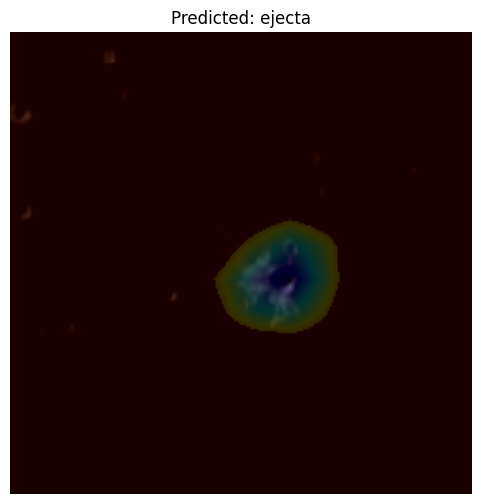

In [129]:
for images, labels in test_ds.take(1):
    test_image = images[0]

img_tensor = tf.expand_dims(test_image, axis=0)
show_gradcam(img_tensor, model, CLASS_NAMES)

In [113]:
def show_image(img):
    img = img.numpy() if hasattr(img, "numpy") else img

    # If model preprocessing was used (VGG / ResNet)
    if img.min() < 0 or img.max() > 1:
        img = img.copy()
        img -= img.min()
        img /= img.max() + 1e-8

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

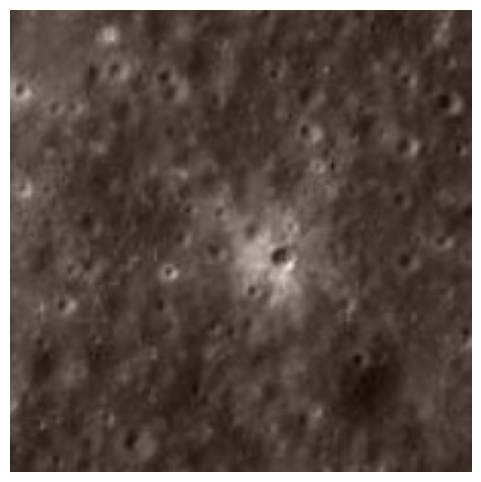

In [114]:
show_image(test_image)

# Check images from 3 classes

In [142]:
# ----------------------------
# Deprocessing for pretrained models
# ----------------------------
def deprocess_image(img, model_type='custom'):
    """
    Converts preprocessed image back to uint8 for visualization.
    Supports VGG16, ResNet50, or custom normalized images.
    """
    img = img.copy().astype(np.float32)

    if model_type == 'vgg16':
        # VGG16 preprocessing: BGR, mean subtracted
        mean = [103.939, 116.779, 123.68]  # BGR
        img[..., 0] += mean[0]
        img[..., 1] += mean[1]
        img[..., 2] += mean[2]
        img = img[..., ::-1]  # BGR -> RGB
    elif model_type == 'resnet50':
        # ResNet50 preprocessing: scale to [-1, 1]
        img = (img + 1.0) * 127.5
    else:  # custom or simple [0,1] scaling
        img = img * 255.0

    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

# ----------------------------
# Side-by-side Grad-CAM
# ----------------------------
def visualize_gradcam_side_by_side(
    model, dataset, class_names, model_type='custom', samples_per_class=3, alpha=0.3
):
    """
    Displays Grad-CAM overlay and original image side by side per class.
    
    Args:
        model: Trained Sequential model
        dataset: tf.data.Dataset (batched)
        class_names: list of class names
        model_type: 'vgg16', 'resnet50', or 'custom'
        samples_per_class: number of images per class to display
        alpha: heatmap transparency
    """
    # Collect examples per class
    class_examples = {i: [] for i in range(len(class_names))}
    for images, labels in dataset:
        for img, lbl in zip(images, labels):
            if len(class_examples[lbl.numpy()]) < samples_per_class:
                class_examples[lbl.numpy()].append(img)
        if all(len(lst) >= samples_per_class for lst in class_examples.values()):
            break

    backbone, classifier = split_model(model)
    last_conv = find_last_conv_layer(backbone)
    
    n_classes = len(class_names)
    plt.figure(figsize=(samples_per_class * 4 * 2, n_classes * 4))  # 2x width for original + overlay
    
    for cls_idx, cls_name in enumerate(class_names):
        for i, img in enumerate(class_examples[cls_idx]):
            img_tensor = tf.expand_dims(img, axis=0)
            heatmap, pred_idx = make_gradcam_heatmap(img_tensor, backbone, classifier, last_conv)
            
            # Deprocess original image for visualization
            img_vis = deprocess_image(img_tensor[0].numpy(), model_type)
            overlay = overlay_heatmap_on_image(img_vis, heatmap, alpha=alpha)
            
            # Original image
            plt.subplot(n_classes, samples_per_class * 2, cls_idx * samples_per_class * 2 + i*2 + 1)
            plt.imshow(img_vis)
            plt.axis("off")
            if i == 0:
                plt.ylabel(cls_name, fontsize=12)
            if cls_idx == 0:
                plt.title("Original", fontsize=10)
            
            # Overlay
            plt.subplot(n_classes, samples_per_class * 2, cls_idx * samples_per_class * 2 + i*2 + 2)
            plt.imshow(overlay)
            plt.axis("off")
            if cls_idx == 0:
                plt.title("Grad-CAM Overlay", fontsize=10)
    
    plt.tight_layout()
    plt.show()


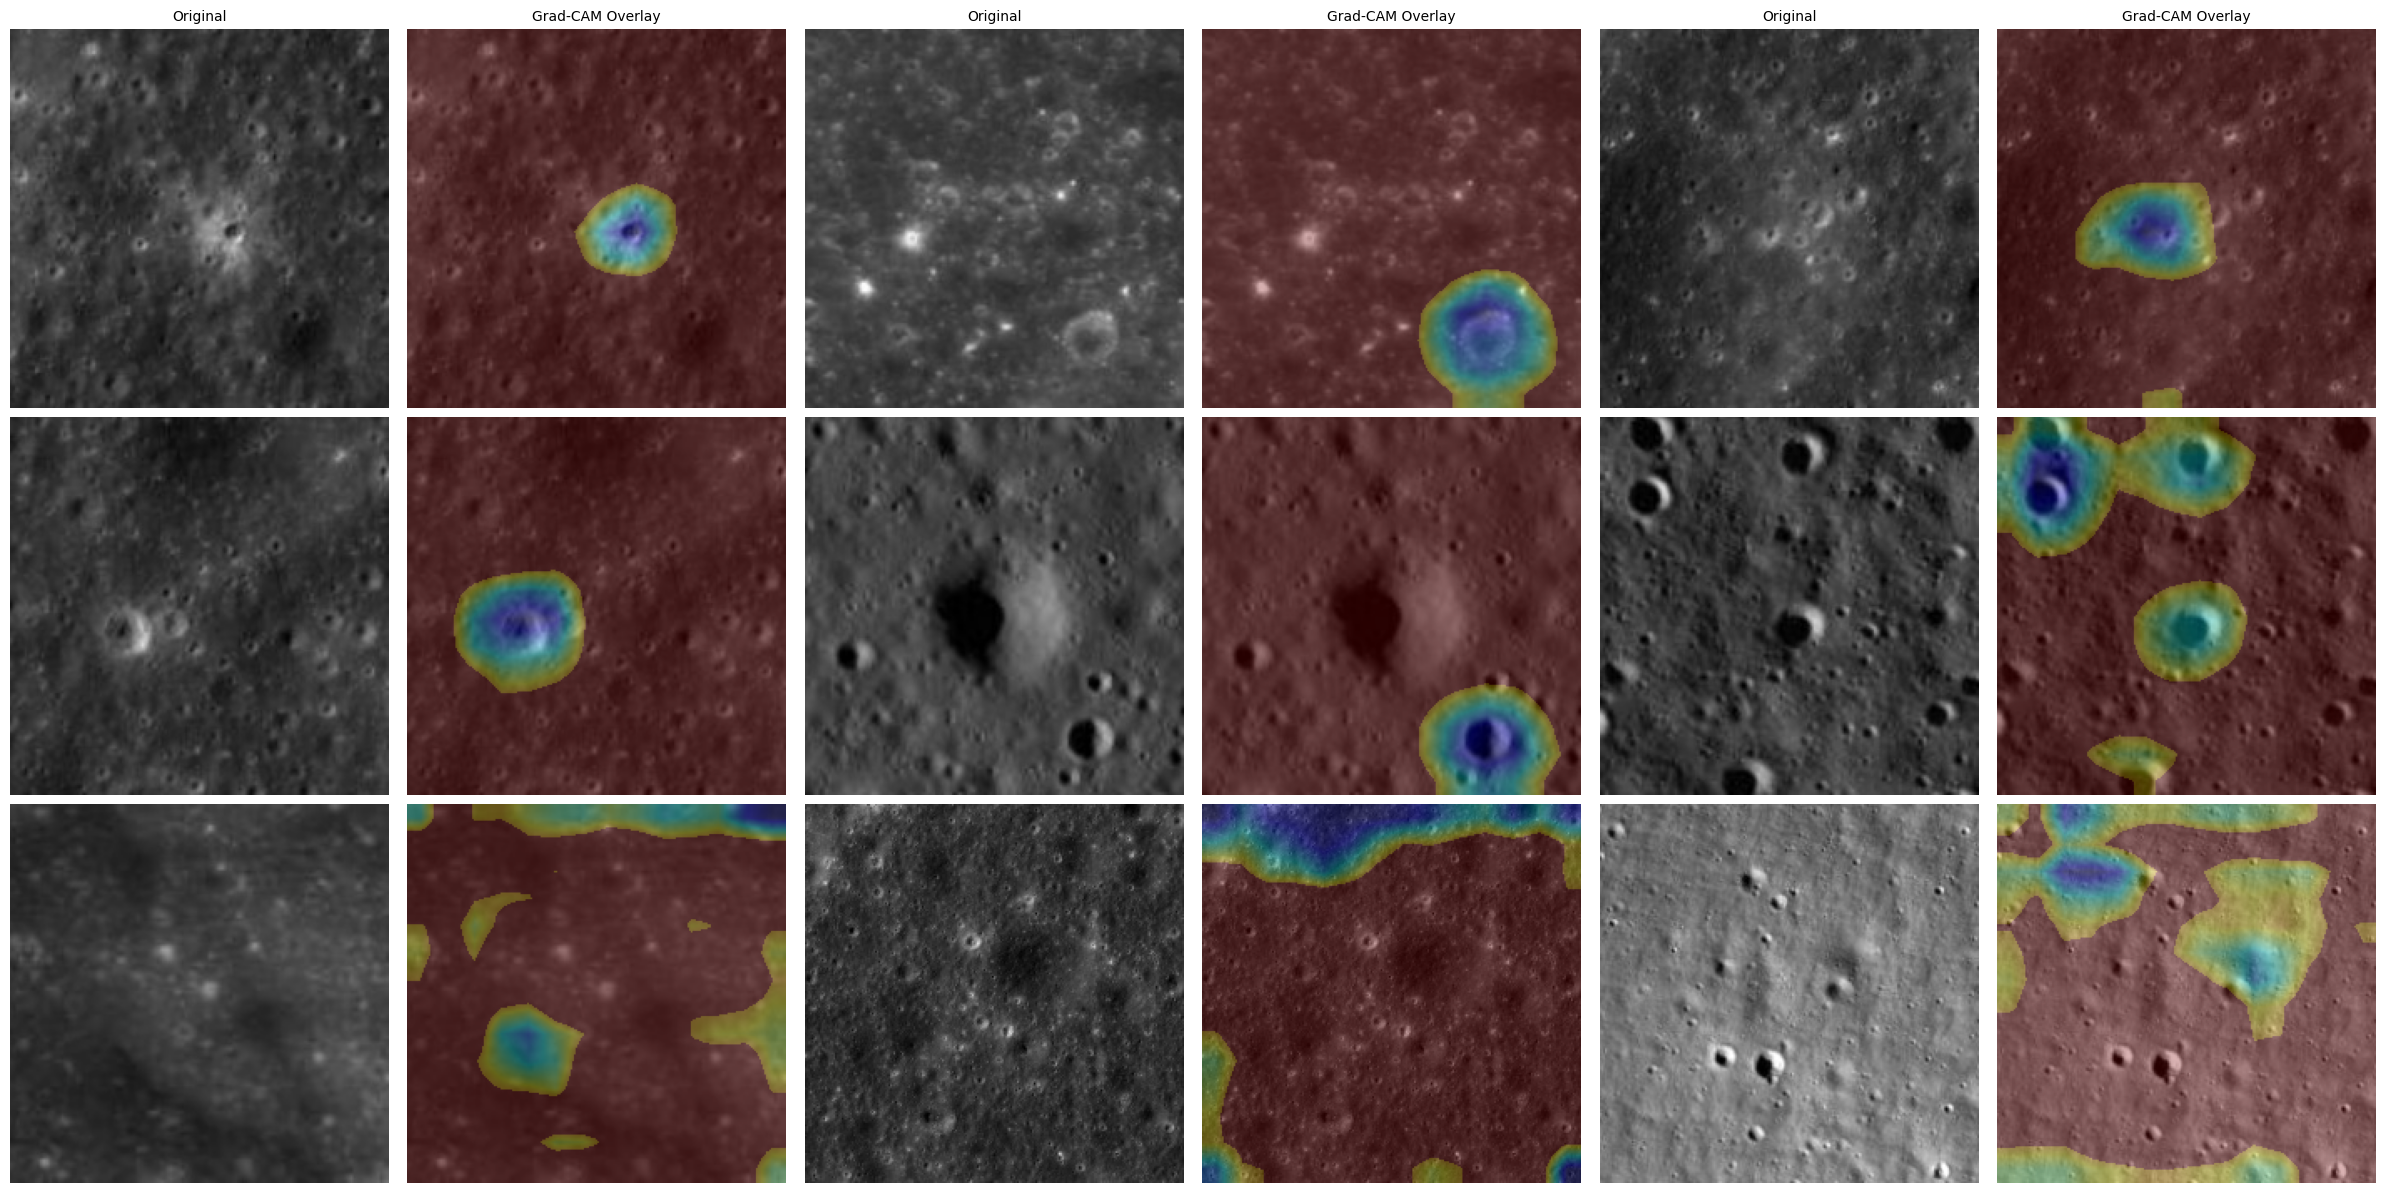

In [143]:
visualize_gradcam_side_by_side(
    model=model,
    dataset=test_ds,
    class_names=CLASS_NAMES,
    model_type='vgg16',  # Change to 'resnet50' or 'custom' for other models
    samples_per_class=3,
    alpha=0.3
)


In [149]:
def visualize_single_image_gradcam(img_tensor, model, class_names, model_type='custom', alpha=0.3):
    """
    Displays the original image and Grad-CAM overlays for each class.

    Args:
        img_tensor: tf.Tensor of shape (1,H,W,3) - preprocessed image
        model: trained Sequential model
        class_names: list of class names
        model_type: 'vgg16', 'resnet50', 'custom'
        alpha: heatmap transparency
    """
    backbone, classifier = split_model(model)
    last_conv = find_last_conv_layer(backbone)

    # Get predictions
    preds = model(img_tensor)
    pred_class = tf.argmax(preds[0]).numpy()

    # Deprocess image for original display
    img_vis = deprocess_image(img_tensor[0].numpy(), model_type)

    n_classes = len(class_names)
    plt.figure(figsize=(5*(n_classes+1), 5))

    # Original image
    plt.subplot(1, n_classes+1, 1)
    plt.imshow(img_vis)
    plt.axis('off')
    plt.title("Original", fontsize=12)

    # Grad-CAM for each class
    for i, cls_name in enumerate(class_names):
        # Use positional argument for pred_index
        heatmap, _ = make_gradcam_heatmap(img_tensor, backbone, classifier, last_conv, i)
        overlay = overlay_heatmap_on_image(img_vis, heatmap, alpha=alpha)

        plt.subplot(1, n_classes+1, i+2)
        plt.imshow(overlay)
        plt.axis('off')
        plt.title(cls_name, fontsize=12)

    plt.tight_layout()
    plt.show()
    print(f"Model prediction: {class_names[pred_class]}")


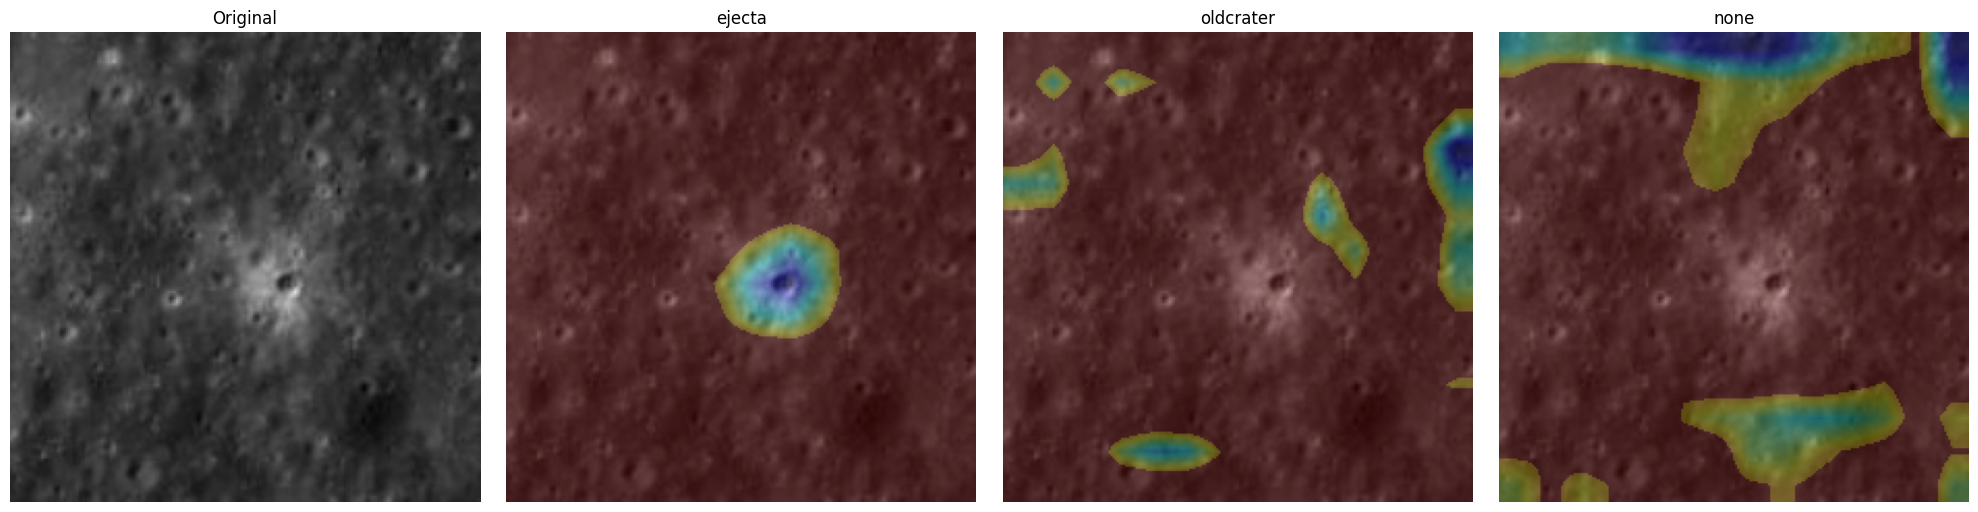

Model prediction: ejecta
True label: ejecta


In [150]:
# Take one image from test set
for images, labels in test_ds.take(1):
    test_img = tf.expand_dims(images[0], axis=0)
    true_label = labels[0].numpy()

visualize_single_image_gradcam(
    test_img,
    model,
    class_names=CLASS_NAMES,
    model_type='vgg16',
    alpha=0.3
)
print("True label:", CLASS_NAMES[true_label])
